In [1]:
import gymnasium as gym
import highway_env
import numpy as np
import matplotlib.pyplot as plt

Episode 1: Total reward = 29.903
Episode 2: Total reward = 25.179
Episode 3: Total reward = 32.715
Episode 4: Total reward = 34.522
Episode 5: Total reward = 35.698


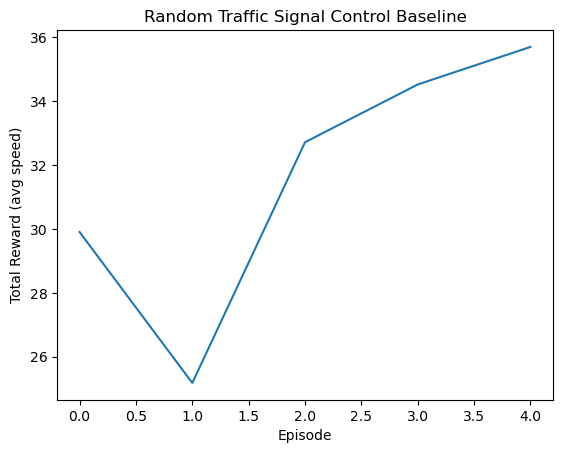

In [2]:
### Simplest One Lane Environment 

class SimpleTrafficSignalEnv:
    """
    一个基于 intersection-v0 的简单红绿灯控制封装。
    动作：0 = 东西方向绿灯，1 = 南北方向绿灯
    奖励：车辆平均速度（越快越好）
    """

    def __init__(self, render_mode="human"):
        # Create base environment with screen size configuration
        config = {
            "screen_width": 1920,  
            "screen_height": 1080,
            "simulation_frequency": 15,
            "policy_frequency": 5,
            "duration": 100,
            "screen_centered": True,
            "scaling": 5.5,
            "render_agent": True,
            "offscreen_rendering": False
        }
        
        # Register custom environment with config
        gym.envs.registration.register(
            id='custom-intersection-v0',
            entry_point='highway_env.envs:IntersectionEnv',
            kwargs={'config': config}
        )
        
        # Create the environment instance
        self.base_env = gym.make("custom-intersection-v0", render_mode=render_mode)
        
        # Initialize traffic light parameters
        self.phase = 0  
        self.step_count = 0
        self.switch_interval = 10

    def reset(self):
        obs, info = self.base_env.reset()
        self.phase = 0
        self.step_count = 0

        # Move ego vehicle off-road (parked)
        ego = self.base_env.unwrapped.vehicle
        ego.position = np.array([15.0, 15.0])
        ego.acceleration = np.array([0.0, 0.0])
        ego.target_speed = 0.0

        return obs, info

    def step(self, action):
        # action ∈ {0, 1} ：红绿灯方向
        self.phase = action
        self.step_count += 1

        # 根据当前红绿灯状态设定模拟规则
        # 注意：highway-env 自身没有信号灯逻辑，我们用奖励反映效果
        obs, reward, done, truncated, info = self.base_env.step(0)

        # 奖励 = 当前平均速度（更高 = 更畅通）
        # speeds = [v.speed for v in self.base_env.road.vehicles if hasattr(v, "speed")]
        speeds = [v.speed for v in self.base_env.unwrapped.road.vehicles if hasattr(v, "speed")]

        avg_speed = np.mean(speeds) if len(speeds) > 0 else 0
        reward = avg_speed / 30.0  # 归一化到 [0, 1]

        return obs, reward, done, truncated, info

    def render(self):
        self.base_env.render()

    def close(self):
        self.base_env.close()


# ========== 运行随机策略 baseline ==========
env = SimpleTrafficSignalEnv(render_mode="human")

episodes = 5
rewards = []

for ep in range(episodes):
    obs, info = env.reset()
    total_reward = 0

    for step in range(200):
        action = np.random.choice([0, 1])  # 随机切换红绿灯
        obs, reward, done, truncated, info = env.step(action)
        total_reward += reward
        if done or truncated:
            break

    rewards.append(total_reward)
    print(f"Episode {ep+1}: Total reward = {total_reward:.3f}")

env.close()

# ========== 绘制奖励曲线 ==========
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward (avg speed)")
plt.title("Random Traffic Signal Control Baseline")
plt.show()


In [6]:
import numpy as np
import gymnasium as gym
from highway_env.envs.common.abstract import AbstractEnv
from highway_env.road.lane import StraightLane
from highway_env.road.road import Road, RoadNetwork
from highway_env.vehicle.controller import ControlledVehicle  # ✅ 直接引入车辆类


class TwoIntersectionsEnv(AbstractEnv):
    def _create_road(self):
        net = RoadNetwork()
        L = 100  # 路口间距
        lane_sep = 4  # 车道间距

        # ===== 主干道 W - I1 - I2 - E =====
        for i in range(2):
            net.add_lane("W", "I1", StraightLane([-L, i * lane_sep], [0, i * lane_sep]))
            net.add_lane("I1", "W", StraightLane([0, -lane_sep - i * lane_sep], [-L, -lane_sep - i * lane_sep]))

        for i in range(2):
            net.add_lane("I1", "I2", StraightLane([0, i * lane_sep], [L, i * lane_sep]))
            net.add_lane("I2", "I1", StraightLane([L, -lane_sep - i * lane_sep], [0, -lane_sep - i * lane_sep]))

        for i in range(2):
            net.add_lane("I2", "E", StraightLane([L, i * lane_sep], [2 * L, i * lane_sep]))
            net.add_lane("E", "I2", StraightLane([2 * L, -lane_sep - i * lane_sep], [L, -lane_sep - i * lane_sep]))

        # ===== 支路（N1/S1 at I1, N2/S2 at I2） =====
        for center, name in [(0, "1"), (L, "2")]:
            # 北向
            for i in range(2):
                net.add_lane(f"N{name}", f"I{name}", StraightLane([center + (i * lane_sep), L], [center + (i * lane_sep), 0]))
                net.add_lane(f"I{name}", f"N{name}", StraightLane([center - (i + 1) * lane_sep, 0], [center - (i + 1) * lane_sep, L]))
            # 南向
            for i in range(2):
                net.add_lane(f"S{name}", f"I{name}", StraightLane([center + (i * lane_sep), -L], [center + (i * lane_sep), 0]))
                net.add_lane(f"I{name}", f"S{name}", StraightLane([center - (i + 1) * lane_sep, 0], [center - (i + 1) * lane_sep, -L]))

        self.road = Road(network=net, np_random=self.np_random)

    def _create_vehicles(self):
        # ✅ 直接使用 ControlledVehicle，而不是 self.action_type
        vehicle = ControlledVehicle.make_on_lane(self.road, ("W", "I1", 0), 5, 0)
        self.vehicle = vehicle
        self.road.vehicles.append(vehicle)

    def _reset(self):
        self._create_road()
        self._create_vehicles()


if __name__ == "__main__":
    env = TwoIntersectionsEnv(render_mode="human")

    obs, info = env.reset()
    done = truncated = False

    while not done and not truncated:
        obs, reward, done, truncated, info = env.step(env.action_space.sample())
        env.render()



NotImplementedError: 